In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

%load_ext autoreload
%autoreload 2

In [2]:
human_meta = pd.read_csv('./data/raw/Metadata/Human19_Metadatav3.csv')
human_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
human_meta.shape

(372, 16)

In [4]:
human_meta.head()

,ABF File,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,Threshold,DC,ZD,Hold,Gain,Offset,Response Channel,Command Channel,RMP,stimulus_type
0,2019_11_26_0010,Human,Nov_26_2019,C1,L5,Gap Free,n.a,n.a,ZD,n.a,1.0,0.0,Vm_Sec(mV),NaN,-71.5,NaN
1,2019_11_26_0011,Human,Nov_26_2019,C1,L5,Gap Free,n.a,n.a,ZD,n.a,1.0,0.0,Vm_Sec(mV),NaN,-71.5,NaN
2,2019_11_26_0018,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,1.0,0.0,Vm_Sec(mV),NaN,-72.9,NaN
3,2019_11_26_0020,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,1.0,0.0,Vm_Sec(mV),NaN,-72.9,NaN
4,2019_11_26_0021,Human,Nov_26_2019,C2,L5,Gap Free,n.a,n.a,ZD,n.a,1.0,0.0,Vm_Sec(mV),NaN,-72.9,NaN


In [5]:
human_meta['Stim Type'].value_counts()

ZAP                     156
White noise             116
Intrinsic Properties     71
Gap Free                 20
Gap free                  6
n.a                       3
Name: Stim Type, dtype: int64

In [6]:
human_meta.stimulus_type.value_counts()

longsquare     56
shortsquare     6
ramp            6
Name: stimulus_type, dtype: int64

In [7]:
human_meta[human_meta.stimulus_type == 'longsquare']['Stim Type'].value_counts()

Intrinsic Properties    56
Name: Stim Type, dtype: int64

In [9]:
intrinsic_meta = human_meta[human_meta['Stim Type'] == 'Intrinsic Properties']

In [10]:
intrinsic_meta.stimulus_type.value_counts()

longsquare     56
shortsquare     6
ramp            6
Name: stimulus_type, dtype: int64

In [12]:
intrinsic_meta.shape

(71, 16)

In [13]:
intrinsic_meta['ABF File'].nunique()

71

## Identify files to be converted
- 503 ABF files from human2019
- need metadata to determine which files are testing intrinsic properties
    - based off metadata, there are 71 files with protocols testing intrinsic properties
- extract ABF version info, time of creation, experimenter and comments from the ABF file

In [11]:
human2019_abf_dir = Path("./data/raw/recordings/Human tissue/Human tissue-White noise_2019/")
human2019_file_info = utils.summary_df(human2019_abf_dir)

In [12]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        return None

# add this column to merge with provided metadata
human2019_file_info['file_id'] = human2019_file_info.file_name.apply(lambda x: Path(x).stem) 
human2019_file_info.drop_duplicates(subset='file_id', keep='first', inplace=True)

#human2019_file_info['timestamp'] = human2019_file_info.path.apply(parse_timestamp)
#human2019_file_info['abf_version'] = human2019_file_info.path.apply(extract_abf_version)
#human2019_file_info['abf_comments'] = human2019_file_info.path.apply(extract_abf_comments)
human2019_file_info['experimenter'] = human2019_file_info.path.apply(check_protocolpath_for_experimenter)

CPU times: user 6.13 s, sys: 2.92 s, total: 9.05 s
Wall time: 10 s


In [13]:
human2019_file_info.shape

(488, 4)

In [14]:
human2019_file_info.file_id.nunique()

488

In [15]:
human2019_file_info.experimenter.value_counts()

Homeira    325
Name: experimenter, dtype: int64

In [16]:
human2019_file_info

,file_name,path,file_id,experimenter
0,19219023.abf,data/raw/recordings/Human tissue/Human tissue-...,19219023,None
1,19219021.abf,data/raw/recordings/Human tissue/Human tissue-...,19219021,Homeira
2,19219005.abf,data/raw/recordings/Human tissue/Human tissue-...,19219005,Homeira
3,19219004.abf,data/raw/recordings/Human tissue/Human tissue-...,19219004,Homeira
4,19219016.abf,data/raw/recordings/Human tissue/Human tissue-...,19219016,None
...,...,...,...,...
498,19o10047.abf,data/raw/recordings/Human tissue/Human tissue-...,19o10047,Homeira
499,19o10043.abf,data/raw/recordings/Human tissue/Human tissue-...,19o10043,Homeira
500,19o10048.abf,data/raw/recordings/Human tissue/Human tissue-...,19o10048,Homeira
501,19o10051.abf,data/raw/recordings/Human tissue/Human tissue-...,19o10051,None


In [17]:
merged_meta = intrinsic_meta.merge(human2019_file_info, left_on='ABF File', right_on='file_id' , how='left').drop('ABF File', axis=1)

In [18]:
merged_meta.shape

(71, 19)

## Extract metadata required for conversion process

In [19]:
# invert the offset values from the provided metadata 
merged_meta.Offset = merged_meta.Offset * (-1)

In [20]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepC'
        
        cell_meta_df = None
        stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}

    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

C2, L3, APV,CNQX,PTX,ZD 10 uM
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/ZD_C2_L3C/Intrinsic Properties_C2_L3C/2019_11_04_0098.abf', 'valid_stim': True, 'stim_amp_vec': array([-350., -300., -250., ...,  250.,  300.,  350.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 15, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
C3, L5, APV,CNQX,PTX, ZD 10 uM
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 16
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C3_L5/ZD_C3_L5/Intrinsic Properties_C3_L5/2019_11_04_0128.abf', 'valid_stim': True, 'stim_amp_vec': array([-350., -300., -250., ...,  300.,  350.,  400.]), 'stim_duration': 0.6, 'stim_start_time': 0

C1,  L5,   RMP -62.9mv,
num_sweeps: 17
stim_dict: {'stim_amp_vec': array([-400., -350., -300., ...,  300.,  350.,  399.]), 'stim_duration': 0.0755, 'stim_start_time': 0.1809, 'stim_end_time': 0.78, 'num_sweeps': 17, 'stim_sampling_rate': 10000, 'stim_chan': 3, 'stim_gain': 0.2, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Jan_29_2019/C1_L5/Intrinsic Properties_C1_L5/19129000.abf', 'valid_stim': True}
----------------------------------------------------------------------------------------------------
C11,L2,   RMP -67.7  mv, 500 um from pia
num_sweeps: 17
stim_dict: {'stim_amp_vec': array([-399., -351., -300., ...,  301.,  350.,  400.]), 'stim_duration': 0.4211, 'stim_start_time': 0.1806, 'stim_end_time': 0.7804, 'num_sweeps': 17, 'stim_sampling_rate': 10000, 'stim_chan': 3, 'stim_gain': 0.2, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Jan_29_2019/C11_L2/Intrinsic Properties_C11_L2/19129058.abf', 'valid_stim': True}
------

C8, L5   RMP -61.6   mv,
num_sweeps: 17
stim_dict: {'stim_amp_vec': array([-400., -350., -300., ...,  300.,  350.,  400.]), 'stim_duration': 0.3788, 'stim_start_time': 0.1806, 'stim_end_time': 0.7804, 'num_sweeps': 17, 'stim_sampling_rate': 10000, 'stim_chan': 3, 'stim_gain': 0.2, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/March_20_ 2019/C8_L5/Intrinsic Properties_C8_L5/19320041.abf', 'valid_stim': True}
----------------------------------------------------------------------------------------------------
C1, L5  , RMP -67 mv
num_sweeps: 17
stim_dict: {'stim_amp_vec': array([-400., -351., -300., ...,  299.,  350.,  399.]), 'stim_duration': 0.213, 'stim_start_time': 0.1806, 'stim_end_time': 0.78, 'num_sweeps': 17, 'stim_sampling_rate': 10000, 'stim_chan': 3, 'stim_gain': 0.2, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/March_28_2019/C1_L5/Intrinsic Properties_C1_L5/19328001.abf', 'valid_stim': True}
-----------------------

C2. L3 RMP -71.9 mv
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 11
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C2_L3C/Intrinsic Properties_C2_L3C/2019_11_28_0038.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  100.,  150.,  200.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'num_sweeps': 11, 'stim_sampling_rate': 20000}
----------------------------------------------------------------------------------------------------
C3. L3 RMP -64.2  mv,
sweepC: [0. 0. 0. ... 0. 0. 0.]
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C3_L3C/Intrinsic Properties_C3_L3C/2019_11_28_0079.abf', 'valid_stim': True, 'stim_amp_vec': array([-300., -250., -200., ...,  300.,  350.,  400.]), 'stim_duration': 0.6, 'stim_start_time': 0.0921, 'stim_end_time': 0.69205, 'n

In [21]:
extracted_meta = pd.DataFrame(results_list)

In [22]:
extracted_meta.columns

Index(['cell_id', 'resp_chan', 'resp_gain', 'rmp_error', 'abf_tag', 'rmp_val',
       'resp_offset', 'abf_version', 'resp_sampling_rate', 'stim_name',
       'file_time', 'stim_chan', 'stim_gain', 'stim_path', 'valid_stim',
       'stim_amp_vec', 'stim_duration', 'stim_start_time', 'stim_end_time',
       'num_sweeps', 'stim_sampling_rate'],
      dtype='object')

In [23]:
extracted_meta.abf_version.value_counts()

2.6.0.0    36
1.8.3.0    35
Name: abf_version, dtype: int64

In [25]:
all_meta = merged_meta.merge(extracted_meta, left_on='file_id', right_on='cell_id')

In [26]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'h2019_meta.csv')

In [28]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [29]:
output_dir = Path('./data/processed/recordings/human2019')
output_dir.mkdir(exist_ok=True, parents=True)

In [34]:
all_meta.iloc[0]

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP                                                             

In [31]:
%%time
errors = []

for i, file_info in all_meta.iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.cell_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_tag}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                                    outputFilePath = str(output_path), 
                                                    acquisitionChannelName = resp_chan, 
                                                    stimulusChannelName = stim_chan,
                                                    metadata=meta, 
                                                    responseGain = file_info.resp_gain, # gain on response channel
                                                    stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                                    responseOffset = file_info.resp_offset, # voltage offset on resp channel
                                                    )
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/ZD_C2_L3C/Intrinsic Properties_C2_L3C/2019_11_04_0098.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP                                                             

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset I-V curve ,-400 pA, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:550: UserWarning: Could not find settings for amplifier unknown of channel Vm_sec.
  warnings.warn(f"Could not find settings for amplifier {amplifier} of channel {adcName}.")
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C3_L5/ZD_C3_L5/Intrinsic Properties_C3_L5/2019_11_04_0128.json with settings.
  warnings.warn(f"Could not find the JSON file 

NWB Conversion complete for 2019_11_04_0098.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C8_L5/ZD/Intrinsic properties_C8_L5/2019_11_26_0103.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0128.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C1_L3C/ZD/Intrinsic Properties_C1_L3C-ZD/2019_11_28_0016.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0103.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C1
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C2_L3C/ZD/Intrinsic Properties_C1_L3C-ZD/2019_11_28_0054.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0016.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C3_L3C/ZD/Intrinsic Properties_C3_L3C-ZD/2019_11_28_0090.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0054.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C3
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C4_L3C/ZD/Intrinsic Properties_C4_L3C-ZD/2019_11_28_0114.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0090.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C4
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C5_L5/ZD/Intrinsic Properties_C5_L5_ZD/2019_11_28_0127.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0114.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                   ZD
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

Successfully converted to data/processed/recordings/human2019/19228044.nwb.
NWB Conversion complete for 19228044.nwb

Data Type                                                         Human
Exp. Date                                                   Feb_28_2019
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -15.2
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19122003.nwb.
NWB Conversion complete for 19122003.nwb

Data Type                                                         Human
Exp. Date                                                   Jan_22_2019
Cell #                                                               C7
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -25.6
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19128040.nwb.
NWB Conversion complete for 19128040.nwb

Data Type                                                         Human
Exp. Date                                                   Jan_28_2019
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -13.0
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19129000.nwb.
NWB Conversion complete for 19129000.nwb

Data Type                                                         Human
Exp. Date                                                   Jan_29_2019
Cell #                                                              C11
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -19.7
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19129014.nwb.
NWB Conversion complete for 19129014.nwb

Data Type                                                         Human
Exp. Date                                                   Jan_29_2019
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -15.8
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19129037.nwb.
NWB Conversion complete for 19129037.nwb

Data Type                                                         Human
Exp. Date                                                   Jan_29_2019
Cell #                                                               C7
Cell Layer                                                           L3
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -18.5
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19129047.nwb.
NWB Conversion complete for 19129047.nwb

Data Type                                                         Human
Exp. Date                                                 March_19_2019
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -18.1
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19320001.nwb.
NWB Conversion complete for 19320001.nwb

Data Type                                                         Human
Exp. Date                                                March_20_ 2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -19.1
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19320022.nwb.
NWB Conversion complete for 19320022.nwb

Data Type                                                         Human
Exp. Date                                                March_20_ 2019
Cell #                                                               C6
Cell Layer                                                          L23
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -16.0
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19320041.nwb.
NWB Conversion complete for 19320041.nwb

Data Type                                                         Human
Exp. Date                                                 March_28_2019
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -21.0
Response Channel                                             Iclamp(mV)
Command Channel   

Successfully converted to data/processed/recordings/human2019/19328019.nwb.
NWB Conversion complete for 19328019.nwb

Data Type                                                         Human
Exp. Date                                                 March_28_2019
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                               20.0
Offset                                                            -24.2
Response Channel                                             Iclamp(mV)
Command Channel   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0001.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


Successfully converted to data/processed/recordings/human2019/19328046.nwb.
NWB Conversion complete for 19328046.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C1
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0002.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0001.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C1
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C1_L3/Intrinsic Properties_C1_L3C/2019_11_04_0003.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0002.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C1
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset Ramp 1S-190-330-20, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0083.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0003.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0084.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0083.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_04_2019/C2_L3/Intrinsic Properties_C2_L3C/2019_11_04_0085.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0084.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_04_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C1_L5/Intrinsic Properties_C1_L5/2019_11_26_0006.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_04_0085.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C2_L5/Intrinsic Properties_C2_L5/2019_11_26_0019.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0006.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C2
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C3_L3/Intrinsic Properties_C3_L3/2019_11_26_0037.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0019.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C3
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C8_L5/Intrinsic Properties_C8_L5/2019_11_26_0094.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0037.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C8
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_26_2019/C9_L5/Intrinsic Properties_C9_L5/2019_11_26_0110.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0094.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_26_2019
Cell #                                                               C9
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C1_L3C/Intrinsic Properties_C1_L3C/2019_11_28_0010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_26_0110.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C1
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C2_L3C/Intrinsic Properties_C2_L3C/2019_11_28_0038.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0010.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C2
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C3_L3C/Intrinsic Properties_C3_L3C/2019_11_28_0079.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0038.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C3
Cell Layer                                                          L3C
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Nov_28_2019/C5_L5/Intrinsic Properties_C5_L5/2019_11_28_0119.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0079.nwb

Data Type                                                         Human
Exp. Date                                                   Nov_28_2019
Cell #                                                               C5
Cell Layer                                                       L5-Int
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 12(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10010.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_11_28_0119.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP            

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10011.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10010.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C1_L5/Intrinsic Properties_C1_L5/19o10012.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10011.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 10(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10045.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10012.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10046.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10045.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C4_L5/Intrinsic Properties_C4_L5/19o10048.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10046.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C4
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 10(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C5_L5/Intrinsic Properties_C5_L5/19o10054.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10048.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C5_L5/Intrinsic Properties_C5_L5/19o10055.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10054.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C5
Cell Layer                                                           L5
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10062.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10055.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C6
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10063.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10062.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C6
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 10(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/October_10_2019_Epileptogenic zone/C6_L2/Intrinsic Properties_C6_L2/19o10065.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10063.nwb

Data Type                                                         Human
Exp. Date                            October_10_2019_Epileptogenic zone
Cell #                                                               C6
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 11(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Sep_03-2019/C1_L2/Intrinsic Properties_C1_L2/2019_09_03_0017.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 19o10065.nwb

Data Type                                                         Human
Exp. Date                                                   Sep_03-2019
Cell #                                                               C1
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 10(pA)
RMP                   

/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:519: UserWarning: Could not find the scale factor for the stimset None, using 1.0 as fallback.
  warnings.warn(
/Users/derek_howard/triplab/x-to-nwb/src/x_to_nwb/ABF2Converter.py:188: UserWarning: Could not find the JSON file data/raw/recordings/Human tissue/Human tissue-White noise_2019/Sep_03-2019/C1_L2/Intrinsic Properties_C1_L2/2019_09_03_0020.json with settings.
  warnings.warn(f"Could not find the JSON file {settings} with settings.")


NWB Conversion complete for 2019_09_03_0017.nwb

Data Type                                                         Human
Exp. Date                                                   Sep_03-2019
Cell #                                                               C1
Cell Layer                                                           L2
Stim Type                                          Intrinsic Properties
Threshold                                                           n.a
DC                                                                  n.a
ZD                                                                  n.a
Hold                                                                n.a
Gain                                                                1.0
Offset                                                             -0.0
Response Channel                                             Vm_Sec(mV)
Command Channel                                               IN 10(pA)
RMP            

In [32]:
errors

[]

## Plot nwb files

In [35]:
ontology_path = "./data/stim_ontology_new_Homeira.json"
nwb_files = utils.summary_df(path=Path('./data/processed/recordings/human2019/'), suffix='.nwb')

In [36]:
nwb_files

,file_name,path
0,19320017.nwb,data/processed/recordings/human2019/19320017.nwb
1,19320001.nwb,data/processed/recordings/human2019/19320001.nwb
2,2019_11_28_0010.nwb,data/processed/recordings/human2019/2019_11_28...
3,2019_11_28_0038.nwb,data/processed/recordings/human2019/2019_11_28...
4,2019_11_26_0019.nwb,data/processed/recordings/human2019/2019_11_26...
...,...,...
66,19128006.nwb,data/processed/recordings/human2019/19128006.nwb
67,19228068.nwb,data/processed/recordings/human2019/19228068.nwb
68,19320030.nwb,data/processed/recordings/human2019/19320030.nwb
69,19129047.nwb,data/processed/recordings/human2019/19129047.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbe

Error<class 'tuple'> is not a stimulus or response PatchClampSeries with file 2019_09_03_0017.nwb


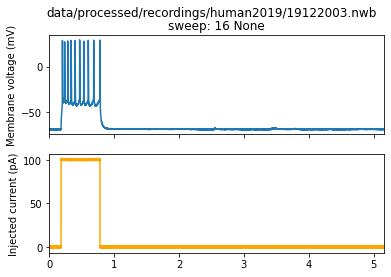

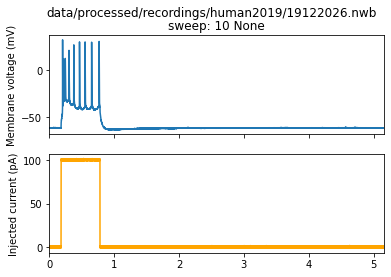

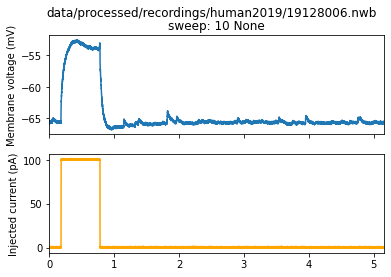

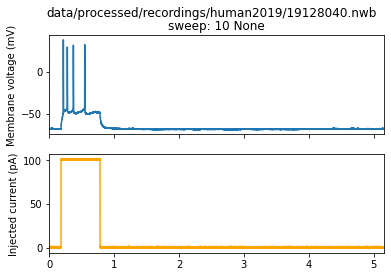

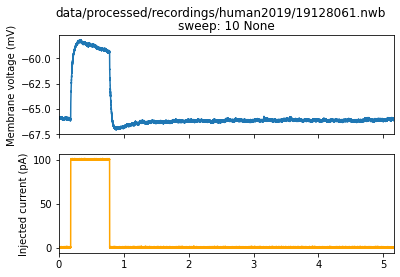

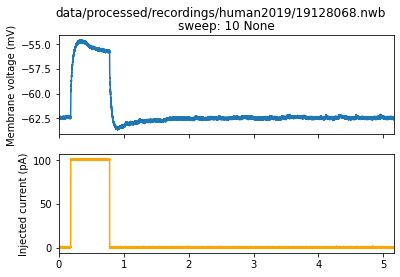

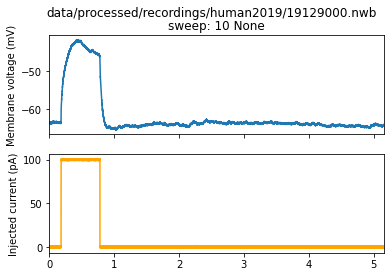

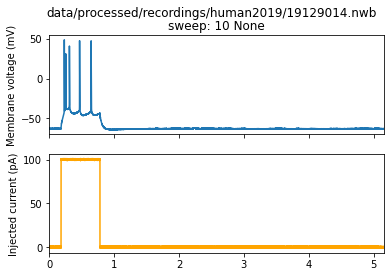

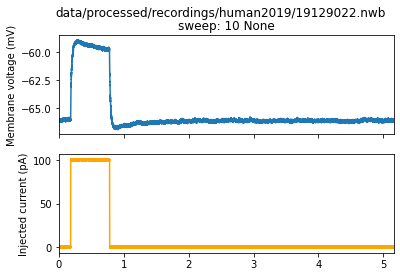

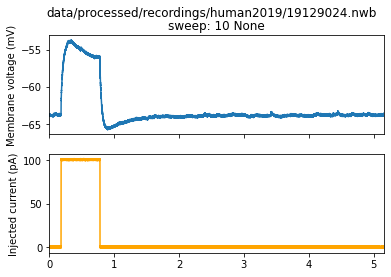

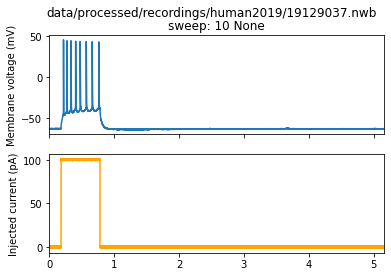

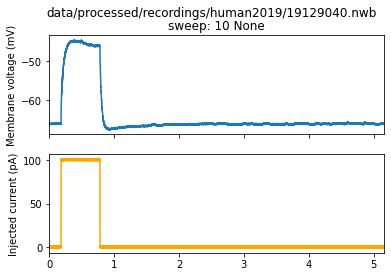

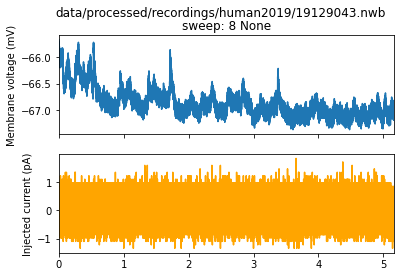

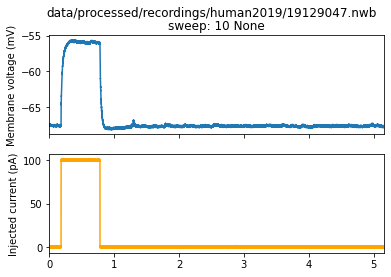

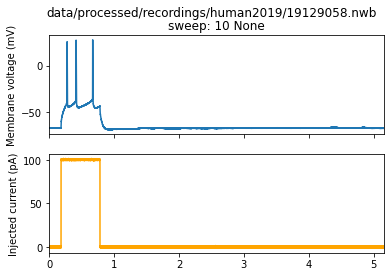

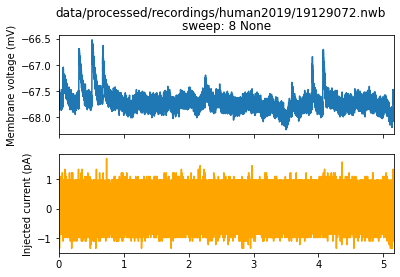

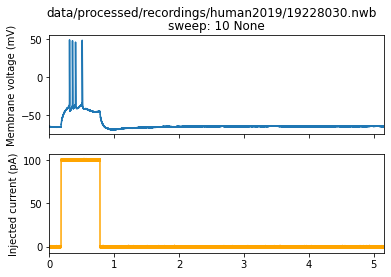

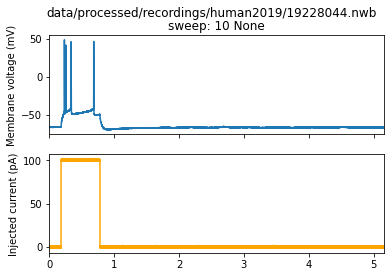

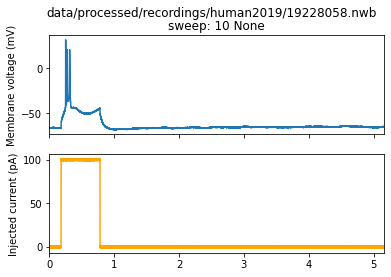

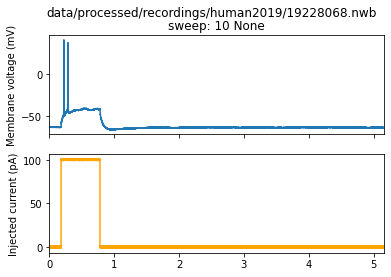

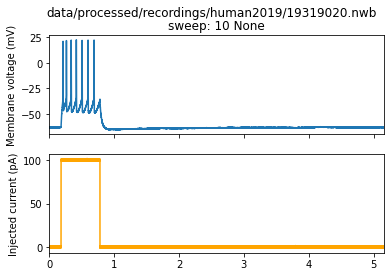

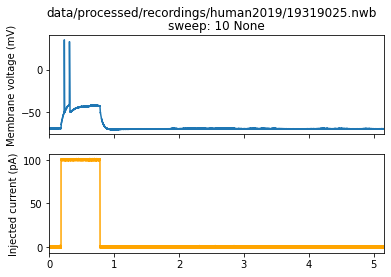

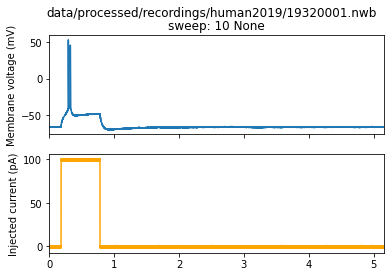

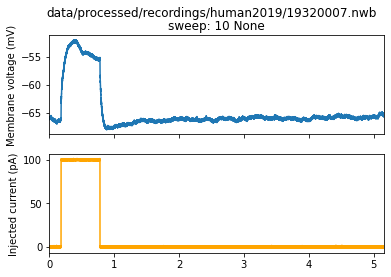

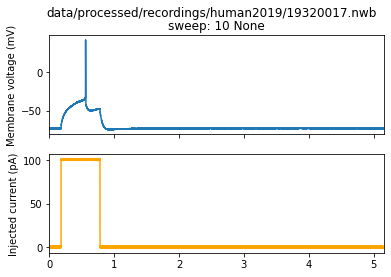

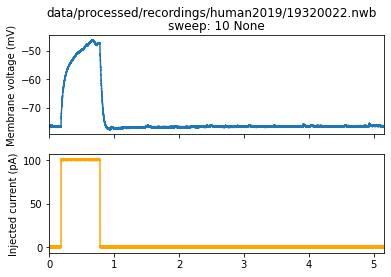

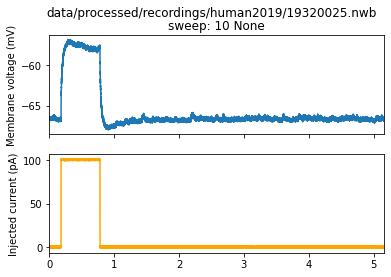

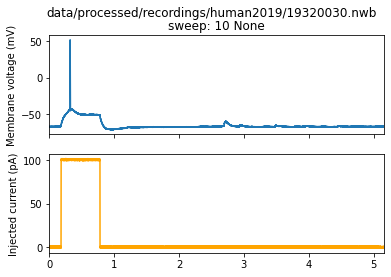

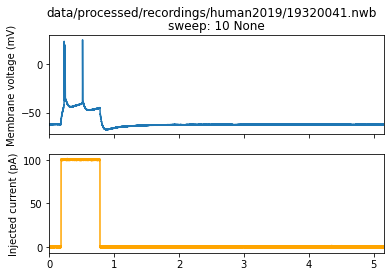

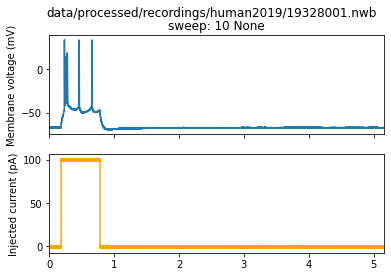

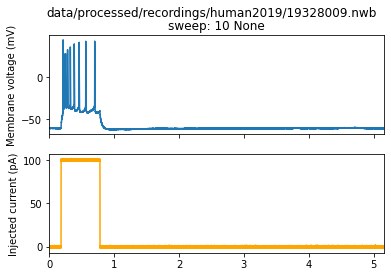

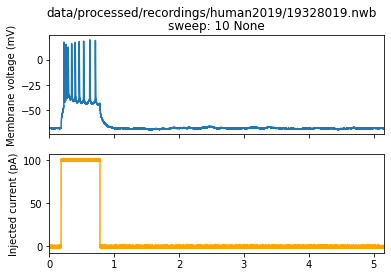

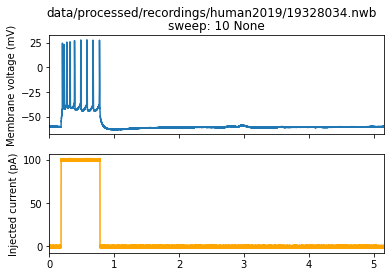

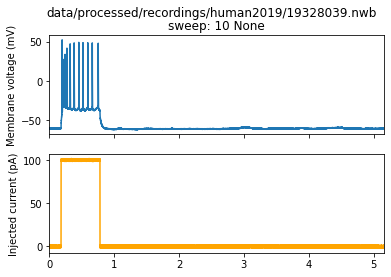

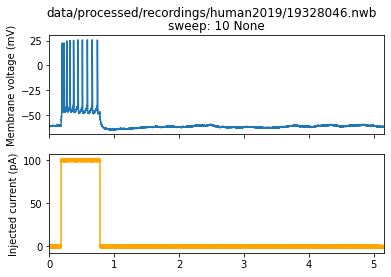

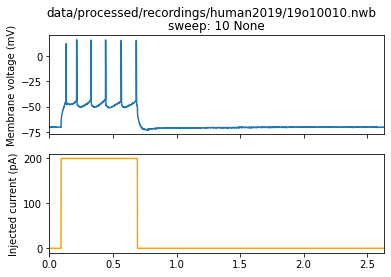

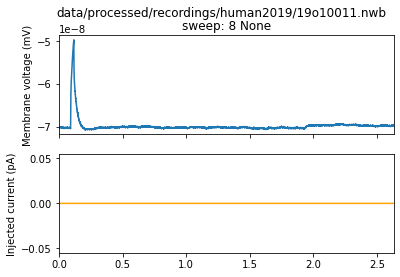

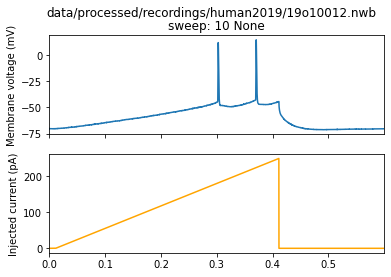

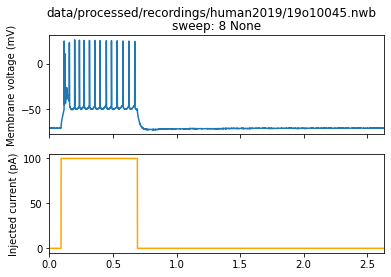

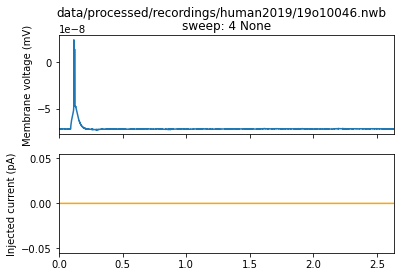

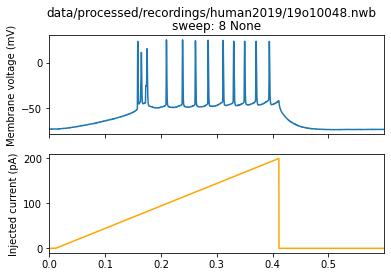

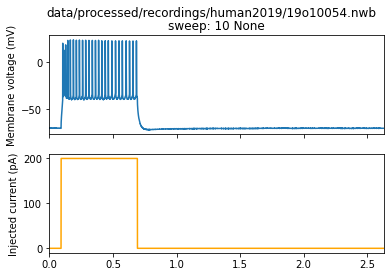

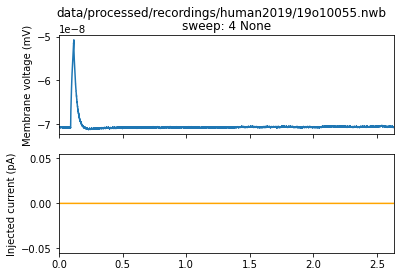

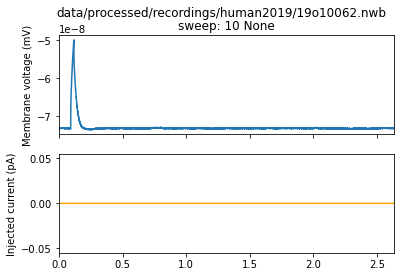

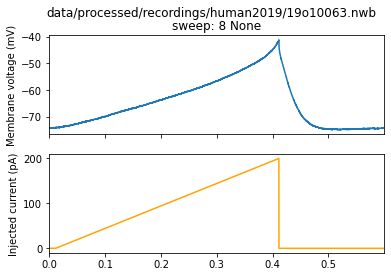

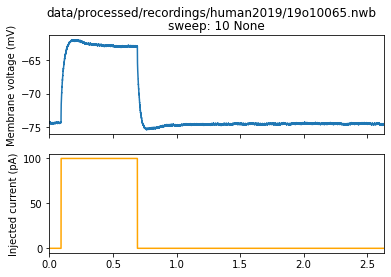

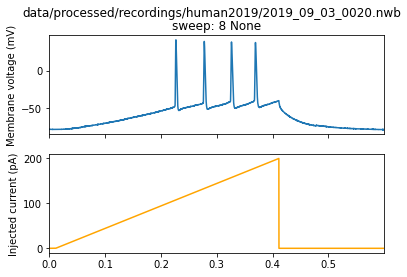

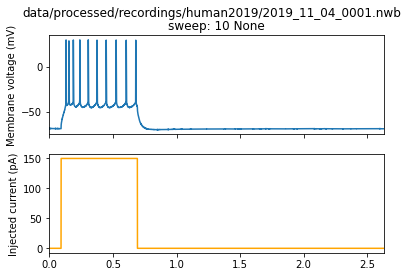

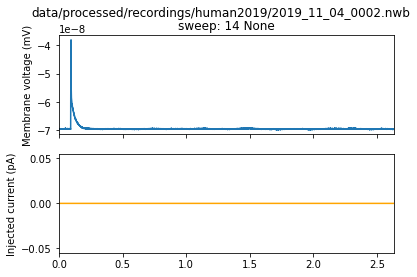

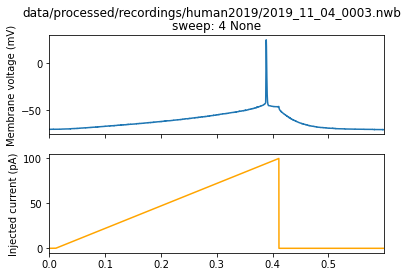

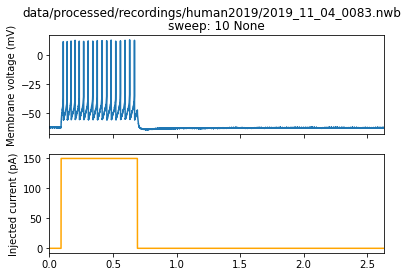

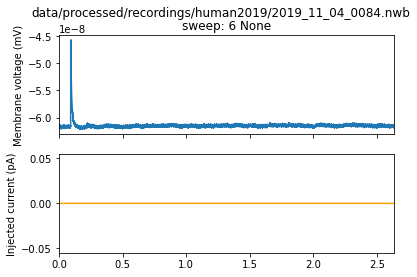

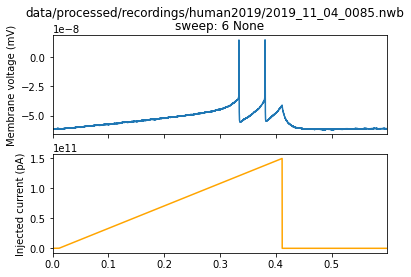

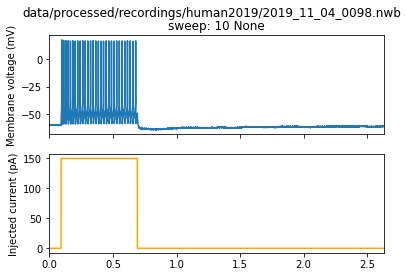

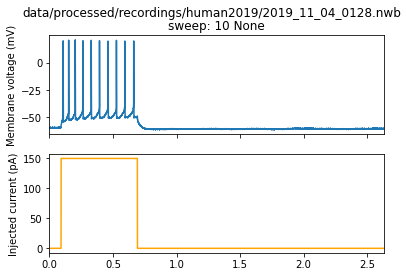

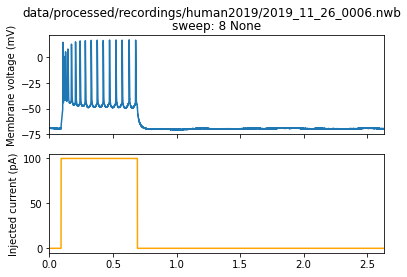

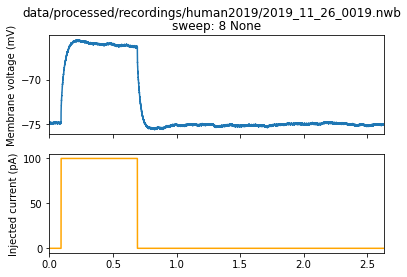

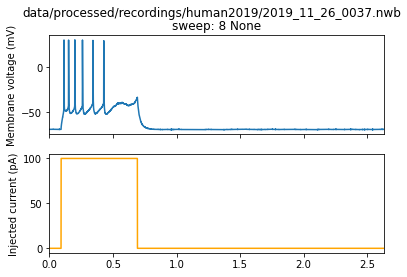

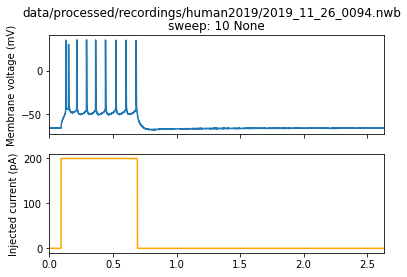

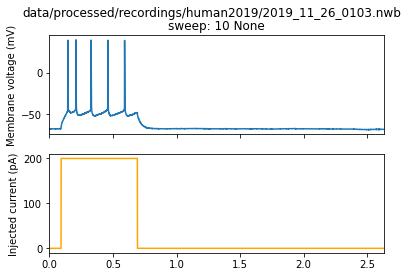

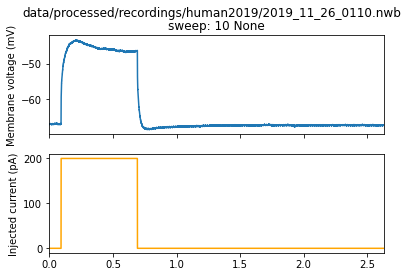

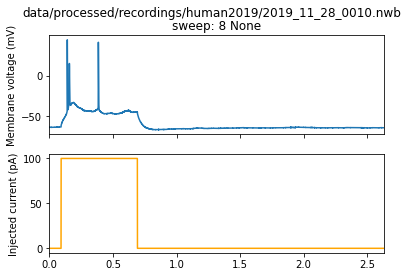

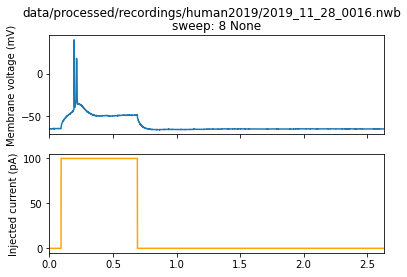

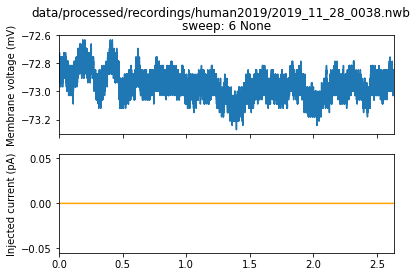

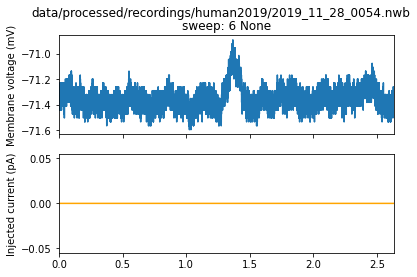

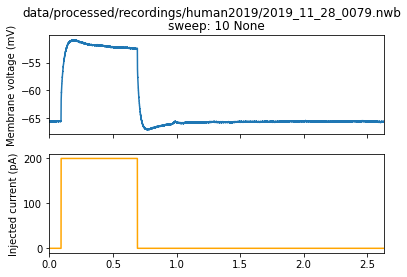

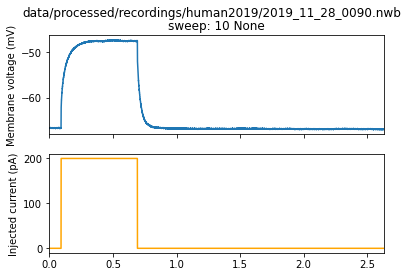

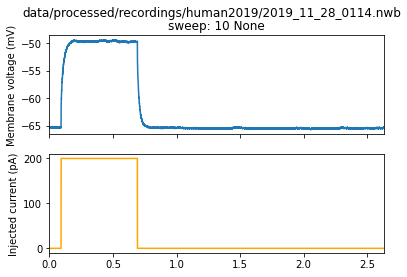

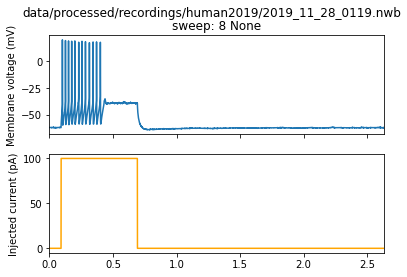

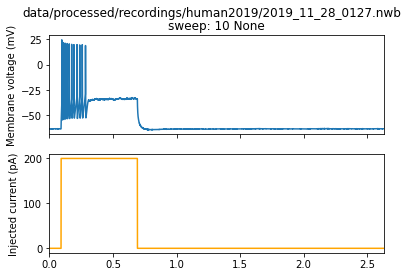

In [37]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    try:
        utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)
    except TypeError as e:
        print(f'Error{e} with file {row.file_name}')

In [38]:
!dandi validate ./data/processed/recordings/human2019/

2021-11-09 17:38:45,452 [    INFO] NumExpr defaulting to 8 threads.
2021-11-09 17:38:48,671 [    INFO] ./data/processed/recordings/human2019/19320017.nwb: ok
2021-11-09 17:38:50,469 [    INFO] ./data/processed/recordings/human2019/19320001.nwb: ok
2021-11-09 17:38:52,211 [    INFO] ./data/processed/recordings/human2019/2019_11_28_0010.nwb: ok
2021-11-09 17:38:53,840 [    INFO] ./data/processed/recordings/human2019/2019_11_28_0038.nwb: ok
2021-11-09 17:38:55,569 [    INFO] ./data/processed/recordings/human2019/2019_11_26_0019.nwb: ok
2021-11-09 17:38:57,390 [    INFO] ./data/processed/recordings/human2019/19228058.nwb: ok
2021-11-09 17:38:59,014 [    INFO] ./data/processed/recordings/human2019/2019_09_03_0017.nwb: ok
2021-11-09 17:39:00,849 [    INFO] ./data/processed/recordings/human2019/19129072.nwb: ok
2021-11-09 17:39:02,823 [    INFO] ./data/processed/recordings/human2019/19129058.nwb: ok
2021-11-09 17:39:04,817 [    INFO] ./data/processed/recordings/human2019/19320007.nwb: ok
2021